In [1]:
!git clone http://github.com/Zapy67/ATML-PA-4 test

fatal: destination path 'test' already exists and is not an empty directory.


In [4]:
!git pull http://github.com/Zapy67/ATML-PA-4 test

From http://github.com/Zapy67/ATML-PA-4
 * branch            test       -> FETCH_HEAD
Already up to date.


In [2]:
%cd test

/kaggle/working/test


In [4]:
!ls

'ATML - PA 4.pdf'   fedprox.ipynb       README.md     task4.ipynb
 data		    fedsam.ipynb        task1.ipynb
 fedgh.ipynb	    fedscaffold.ipynb   task2.ipynb
 fed_lib	    LICENSE	        task3.ipynb


#  FedSam & Local Optimization

In [5]:
import torch
import torch.nn as nn

In [10]:
!pip install fedlab

In [6]:
import fed_lib
import importlib
importlib.reload(fed_lib)

<module 'fed_lib' from '/kaggle/working/test/fed_lib/__init__.py'>

In [7]:
from fed_lib import fed_methods, fed_model, utils
importlib.reload(fed_methods)
importlib.reload(fed_model)
importlib.reload(utils)

10:01:43 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


<module 'fed_lib.utils' from '/kaggle/working/test/fed_lib/utils.py'>

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
trainset, testset = utils.get_cifar10()

In [10]:
import matplotlib.pyplot as plt
def plot_fed_vs_central_acc(metrics, title="FedAvg vs Central Test Accuracy"):
    """
    Args:
        metrics (dict): self.round_metrics dictionary from FedSGD.
    """
    fed_acc = metrics.get('fed_test_acc', [])
    central_acc = metrics.get('central_test_acc', [])

    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='FedAvg (Server) Accuracy')
    plt.plot(rounds, central_acc, marker='s', label='Central Model Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [11]:
def fed_sam_exp(lr=1e-3, num_steps=5, num_clients=5, partition="dirichlet", alpha=10000,device=device, global_runs=20, verbose=False, sampling_frac=1.0, rho=1e-3):
        fed = fed_model.Federation(num_clients=num_clients, federate_method=None, partition=partition, domains=None, alpha=alpha, device=device, batch_size=64, pin_memory=True, num_workers=2)
        client_loaders = fed.client_dataloaders
        client_weights = [len(client.dataset.indices)/len(fed.centralized_train_loader) for client in client_loaders]
        
        fed_meth = fed_methods.FedSAM(local_epochs=1, aggregation_steps=num_steps, client_weights=client_weights, sample_fraction=sampling_frac, rho=rho)
        fed.set_method(fed_meth)
        fed.train(global_runs, lr=lr, verbose=verbose, train_central=False)

        return fed

In [12]:
import matplotlib.pyplot as plt

def plot_metrics(metrics:dict, title:str, label: str, label_desc:str):
    metric_map = {
        'fed_test_acc': 'Test Accuracy',
        'fed_test_loss': 'Test Loss',
        'client_drift': 'Client Drift (Norm)'
    }
    metric_order = ['fed_test_acc', 'fed_test_loss', 'client_drift']
    k_values = sorted(metrics.keys())

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    fig.suptitle(title, fontsize=14)

    for i, metric_key in enumerate(metric_order):
        ax = axes[i]
        for k in k_values:
            values = metrics[k][metric_key]
            rounds = list(range(1, len(values) + 1))
            ax.plot(rounds, values, label=f'{label}={k}')
            
        ax.set_ylabel(metric_map[metric_key])
        ax.grid(axis='y', linestyle='--', alpha=0.6)    
        ax.legend(title=f'{label_desc} ({label})', loc='upper left')
            
    axes[-1].set_xlabel('Global Round')
    plt.show()

In [ ]:
#experimental setup 1.
from IPython.display import clear_output

metrics_exp_1 = {}
total_samples = len(trainset.dataset)
for alpha in [0.01, 0.1, 0.5, 1, 5, 10]: 
    f = fed_sam_exp(lr=1e-2, rho=2e-3,num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, alpha=alpha)
    metrics_exp_1[alpha] = f.federated_method.round_metrics
    clear_output(wait=True)


--- Round 1/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 7.155935e-01
Client Drift Std: 2.587553e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :6.829956e-01
Client Number: 3 Drift :7.021642e-01
Client Number: 2 Drift :7.100972e-01
Client Number: 0 Drift :7.220268e-01
Client Number: 1 Drift :7.606840e-01

Evaluate on round 1:


FedSAM  | Test Loss: 1.9974, Test Acc: 26.08%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.909768e-01
Client Drift Std: 4.248863e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.258286e-01
Client Number: 3 Drift :5.556980e-01
Client Number: 0 Drift :6.168085e-01
Client Number: 1 Drift :6.216402e-01
Client Number: 2 Drift :6.349087e-01

Evaluate on round 2:


FedSAM  | Test Loss: 1.7733, Test Acc: 33.24%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.130843e-01
Client Drift Std: 4.635405e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :4.353822e-01
Client Number: 3 Drift :4.851125e-01
Client Number: 0 Drift :5.424443e-01
Client Number: 1 Drift :5.425935e-01
Client Number: 2 Drift :5.598887e-01

Evaluate on round 3:


FedSAM  | Test Loss: 1.6523, Test Acc: 37.84%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 4.769534e-01
Client Drift Std: 4.727547e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :4.014503e-01
Client Number: 3 Drift :4.414871e-01
Client Number: 0 Drift :5.090355e-01
Client Number: 1 Drift :5.102575e-01
Client Number: 2 Drift :5.225368e-01

Evaluate on round 4:


FedSAM  | Test Loss: 1.5867, Test Acc: 39.81%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 4.587001e-01
Client Drift Std: 4.605647e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.814339e-01
Client Number: 3 Drift :4.315424e-01
Client Number: 0 Drift :4.847164e-01
Client Number: 1 Drift :4.893111e-01
Client Number: 2 Drift :5.064965e-01

Evaluate on round 5:


FedSAM  | Test Loss: 1.5271, Test Acc: 42.25%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs


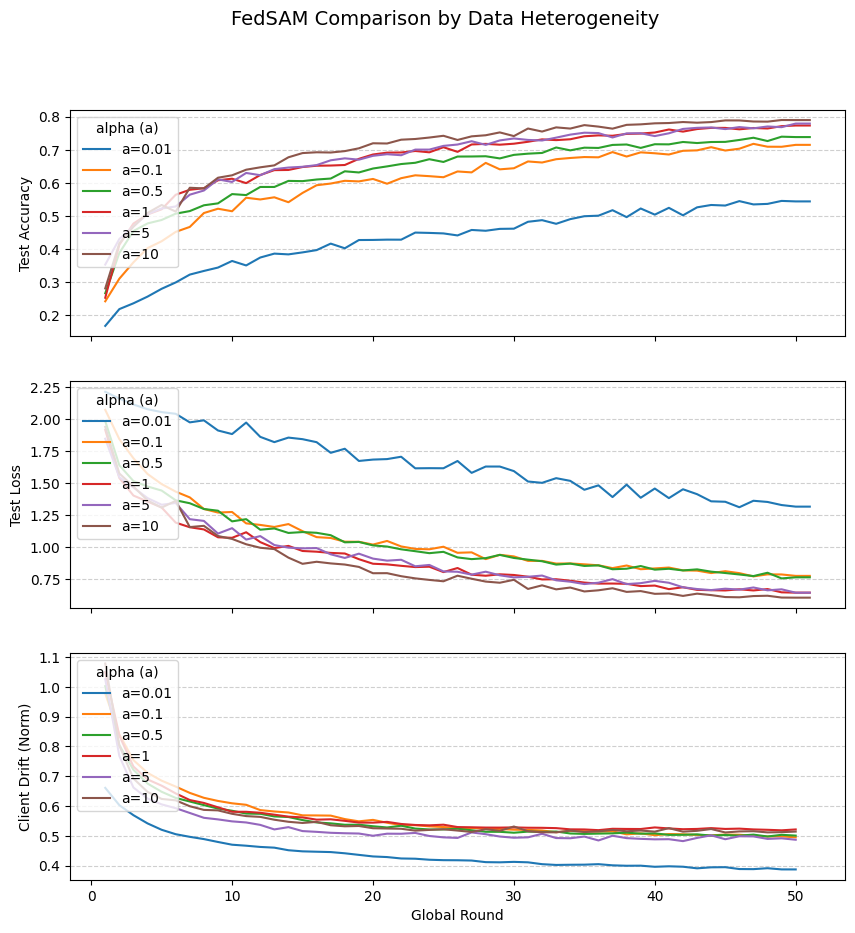

In [21]:
plot_metrics(metrics_exp_1, "FedSAM Comparison by Data Heterogeneity", label="a", label_desc="alpha")

In [ ]:
loaders = utils.

ModuleNotFoundError: No module named 'utils'